### Tensorflow model

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, activations, losses, Model, Input
from tensorflow.nn import leaky_relu
import numpy as np
from itertools import combinations
from tensorflow.keras.utils import plot_model, Progbar
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# model architecture
class RankNet(Model):
    def __init__(self):
        super().__init__()
        self.dense = [layers.Dense(16, activation=leaky_relu), layers.Dense(8, activation=leaky_relu)]
        self.o = layers.Dense(1, activation='linear')
        self.oi_minus_oj = layers.Subtract()
    
    def call(self, inputs):
        xi, xj = inputs
        densei = self.dense[0](xi)
        densej = self.dense[0](xj)
        for dense in self.dense[1:]:
            densei = dense(densei)
            densej = dense(densej)
        oi = self.o(densei)
        oj= self.o(densej)
        oij = self.oi_minus_oj([oi, oj])
        output = layers.Activation('sigmoid')(oij)
        return output
    
    def build_graph(self):
        x = [Input(shape=(10)), Input(shape=(10))]
        return Model(inputs=x, outputs=self.call(x))
    
def plot_metrics(train_metric, val_metric=None, metric_name=None, title=None, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(train_metric,color='blue',label=metric_name)
    if val_metric is not None: plt.plot(val_metric,color='green',label='val_' + metric_name)
    plt.legend(loc="upper right")
    
def predict_ranking(model, docks):
    """
    Predict the ranking of docks using a trained RankNet model.
    
    Args:
        model (RankNet): A trained RankNet model.
        docks (np.array): A 2D numpy array where each row represents a dock's features.
    
    Returns:
        np.array: A NumPy array representing the predicted ranking of docks.
    """
    # Number of docks
    n_docks = docks.shape[0]
    
    # Generate all pairs of docks
    dock_indices = np.arange(n_docks)
    dock_pairs = np.array(list(combinations(dock_indices, 2)))
    
    # Prepare input arrays for model prediction
    xi = docks[dock_pairs[:, 0]]
    xj = docks[dock_pairs[:, 1]]
    
    # Predict pairwise preferences
    pairwise_preds = model.predict([xi, xj])
    
    # Initialize score array
    scores = np.zeros(n_docks)
    
    # Aggregate pairwise predictions into scores
    for (i, j), pred in zip(dock_pairs, pairwise_preds):
        if pred > 0.5:  # i is preferred over j
            scores[i] += 1
        else:           # j is preferred over i
            scores[j] += 1
    
    # Sort docks by their scores in descending order
    ranked_indices = np.argsort(-scores)  # Descending order
    
    return ranked_indices

In [11]:

# generate data
nb_query = 20
query = np.array([i+1 for i in range(nb_query) for x in range(int(np.ceil(np.abs(np.random.normal(0,scale=15))+2)))])
doc_features = np.random.random((len(query), 10))
doc_scores = np.random.randint(5, size=len(query)).astype(np.float32)

# put data into pairs
xi = []
xj = []
pij = []
pair_id = []
pair_query_id = []
for q in np.unique(query):
    query_idx = np.where(query == q)[0]
    for pair_idx in combinations(query_idx, 2):
        pair_query_id.append(q)
        
        pair_id.append(pair_idx)
        i = pair_idx[0]
        j = pair_idx[1]
        xi.append(doc_features[i])
        xj.append(doc_features[j])
        
        if doc_scores[i] == doc_scores[j]:
            _pij = 0.5
        elif doc_scores[i] > doc_scores[j]:
            _pij = 1
        else: 
            _pij = 0
        pij.append(_pij)
        
xi = np.array(xi)
xj = np.array(xj)
pij = np.array(pij)
pair_query_id = np.array(pair_query_id)

xi_train, xi_test, xj_train, xj_test, pij_train, pij_test, pair_id_train, pair_id_test = train_test_split(
    xi, xj, pij, pair_id, test_size=0.2, stratify=pair_query_id)


In [12]:
xi.shape

(1479, 10)

In [13]:
# train model using compile and fit
ranknet = RankNet()
ranknet.compile(optimizer='adam', loss='binary_crossentropy')
history = ranknet.fit([xi_train, xj_train], pij_train, epochs=20, batch_size=1, validation_data=([xi_test, xj_test], pij_test))

Epoch 1/20
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.6839 - val_loss: 0.6597
Epoch 2/20
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6747 - val_loss: 0.6506
Epoch 3/20
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6758 - val_loss: 0.6440
Epoch 4/20
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6485 - val_loss: 0.6348
Epoch 5/20
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.6430 - val_loss: 0.6195
Epoch 6/20
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6218 - val_loss: 0.6106
Epoch 7/20
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6073 - val_loss: 0.5969
Epoch 8/20
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5916 - val_loss: 0.5891
Epoch 9/20
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5819 - val_loss: 0.5726
Epoch 10/20
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5629 - val_loss: 0.5620
Epoch 11/20
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5432 - val_loss: 0.5554
Epoch 12/20
1183/1183 ━━━━━━━━

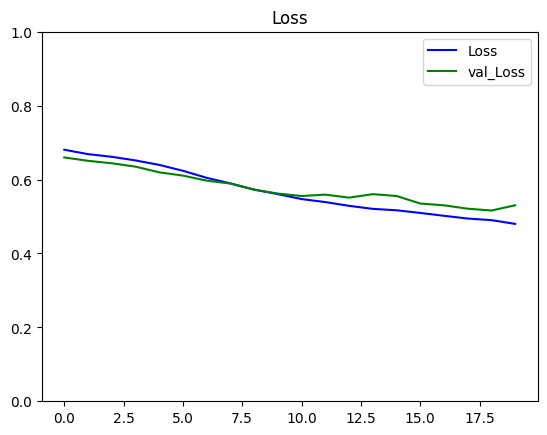

In [14]:
# plot loss history
plot_metrics(history.history['loss'], history.history['val_loss'], "Loss", "Loss", ylim=1.0)

In [22]:
import pandas as pd

docks = np.random.rand(10, 10) 

n_docks = docks.shape[0]

# Generate all pairs of docks
dock_indices = np.arange(n_docks)
dock_pairs = np.array(list(combinations(dock_indices, 2)))

# Prepare input arrays for model prediction
xi1 = docks[dock_pairs[0:1, 0]]
xj2 = docks[dock_pairs[0:1, 1]]

# Predict pairwise preferences
pairwise_preds = ranknet.predict([xi1, xj2])

# pairwise_preds = ranknet.predict([docks[1], docks[2]])

# df_results = pd.DataFrame(columns = ["data", "pred"])

# for q in np.unique(query):
#     query_idx = np.where(query == q)[0]
#     ranking = predict_ranking(ranknet, doc_features[query_idx])
#     comparison = np.stack((ranking, doc_scores[query_idx]), axis = 1)
#     temp = pd.DataFrame(comparison, columns = ["data", "pred"])
#     df_results = pd.concat((df_results, temp))

pairwise_preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


array([[0.8308945]], dtype=float32)

In [ ]:
df_results.to_excel("results.xlsx")

In [24]:
xi1

array([[0.98714026, 0.84109486, 0.52613459, 0.55088681, 0.39183347,
        0.32946889, 0.72804014, 0.12054921, 0.50518656, 0.97684971]])